In [ ]:
#Updated LDA for the positive COVID responses to the NSHAP supplement 
#inspired by this article and code 
#https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2 
#https://nicharuc.github.io/topic_modeling/

In [1]:
#load the required packages 
import pandas as pd #dataframes
import numpy as np #arrays
import re #regular expressions

from wordcloud import WordCloud #word cloud
import matplotlib.pyplot as plt 
import seaborn as sns 

import nltk #stopwords
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess 
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
import gensim.corpora as corpora



import pyLDAvis
from pyLDAvis import gensim_models 
import pickle 
import os
from pprint import pprint



#preprocessing 
nltk.download('punkt')
nltk.download("stopwords")


/home/jadebenson/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to /home/jadebenson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jadebenson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
#load in the manually spell-checked data 
#overtly negative responses still included 
raw_responses = pd.read_csv("manual_cleaned_COVID_responses.csv")
raw_responses.head(10)

,su_id,pos1,pos2
0,20594711,Yes,APPRECIATE FAMILY MORE
1,10021811,No,-5
2,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING
3,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE
4,20899251,No,-5
5,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY..."
6,20944631,No,-5
7,20060281,No,-5
8,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...
9,20399981,No,-5


In [103]:
#how many responses in total? 
len(raw_responses) #2,672
#excellent, there were 2,671 interviewed in total for the COVID supplement 
#this includes 22 respondents that weren't in W3. Check on what to do about them...

2672

In [105]:
#Remove all the non-responses
raw_responses = raw_responses.replace("-3", np.nan)
raw_responses = raw_responses.replace("-5", np.nan)
raw_responses = raw_responses.replace("-6", np.nan)
pos_responses = raw_responses.dropna()

In [106]:
#how many positive responses are there
#there should be 947... 
len(pos_responses)

947

In [6]:
#how fix this? Go to original stata file with the indicator variable, make a subset with only the SU_IDS of those respondents with positive responses 
#save that as an excel file, import into this notebook, compare whether the su_id columns equal each other and if not where is the discrepancy... 
#pos_suids = pd.read_csv("pos_suids.csv")
#pos_suids.head(10)
#len(pos_suids)

#find_missing_responses = pos_suids.merge(pos_responses, how = "outer", on = "su_id")
#find_missing_responses[find_missing_responses.isnull().any(axis=1)]
#missing su_id is 20218642
#fixed it was missing because someone wrote NA (I wrote it out to be "NOT APPLCIABLE" so it doesn't automatically drop)
#there's another one that gets dropped because it's "N/A"
#su_id is 10036931

#now thinking about it - I'm going to drop these two 

In [107]:
# load in the Spanish translations 
translations = pd.read_csv("Spanish_Translations.csv")
translations

,SU_ID,Original,Jade,Yadira,Unnamed: 4,Consolidated
0,10008180,JESUS VIENE PRONTO,Jesus comes soon,NaN,NaN,Jesus comes soon
1,21608711,CAMBIE DE TRABAJO YAHORO MESIENTO MAS COMODA Q...,I changed jobs and now I feel more comfortable...,I switched jobs so now I feel more comfortable...,NaN,I switched jobs so now I feel more comfortable...
2,20844041,APRECIAT MUCHO MAS A LA FAMILIA Y AMIGOS YA QU...,Appreciate family and friends much more since ...,To appreciate family and friends much more sin...,NaN,To appreciate family and friends much more sin...
3,10039960,SI ME HA INSENADO A VIVIR MEJOR EN COMPANIES D...,Yes this has taught me to live better with my ...,"Yes, it has taught me to live better in the co...",NaN,"Yes, it has taught me to live better in the co..."
4,20960781,MIRE LE PUEDO DECIR QUE HASTA-AHORITA ME SIENT...,Look I can tell you that until now I feel good...,Look what I can say is that up until right now...,NaN,Look what I can say is that up until right now...
5,20201761,EL PODER AYUDAR M�S A LAS PERSONAS,To be able to help people more,NaN,NaN,To be able to help people more
6,10039961,"SI, POR SUPUESTO, ESTO NO ENSENA CLARAMENTE, Q...","Yes, of course, this did not teach me clearly,...","Yes, of course, this clearly teaches me, that ...",NaN,"Yes, of course, this clearly teaches me, that ..."
7,21799681,"BUENO , YO TOMABA ALCOHOL SOCIAL LOS FIN DE S...","Good, I would socially drink alcohol on the we...","Well, I used to be a social drinker on weekend...",NaN,"Well, I used to be a social drinker on weekend..."
8,10028341,MOSOTROS IM PRE ES TUNOS EN CORZA NOMAS VANES ...,NaN,NaN,NaN,NaN
9,10008161,MI MATRIMONIO ESTAMPS MAS UNDIOS.,My marriage is closer.,NaN,NaN,My marriage is closer.


In [108]:
len(translations)

48

In [109]:
#merge in to replace the Spanish responses in main responses with translated versions 
trans_small = translations[["SU_ID", "Consolidated"]]
trans_small.head()

,SU_ID,Consolidated
0,10008180,Jesus comes soon
1,21608711,I switched jobs so now I feel more comfortable...
2,20844041,To appreciate family and friends much more sin...
3,10039960,"Yes, it has taught me to live better in the co..."
4,20960781,Look what I can say is that up until right now...


In [110]:
all_responses = pos_responses.merge(trans_small, how = "outer", left_on = "su_id", right_on = "SU_ID")
all_responses.head()

,su_id,pos1,pos2,SU_ID,Consolidated
0,20594711,Yes,APPRECIATE FAMILY MORE,NaN,NaN
1,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING,NaN,NaN
2,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE,NaN,NaN
3,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY...",NaN,NaN
4,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...,NaN,NaN


In [111]:
nona_responses = all_responses.dropna(thresh=2)
nona_responses.pos2.update(nona_responses.Consolidated)
nona_responses.head(20)

,su_id,pos1,pos2,SU_ID,Consolidated
0,20594711,Yes,APPRECIATE FAMILY MORE,NaN,NaN
1,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING,NaN,NaN
2,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE,NaN,NaN
3,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY...",NaN,NaN
4,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...,NaN,NaN
5,20244282,Yes,MORE IN TUNE WITH STAYING HEALTHY AND AVOIDING...,NaN,NaN
6,20097051,Yes,BETTER WORK/LIFE BALANCE. I'M SLEEPING MORE.,NaN,NaN
7,10024340,Yes,"BETTER FRAME OF MIND, CAREFUL OF OTHERS, MAKES...",NaN,NaN
8,20365192,Yes,MY DAUGHTER AND I TORE OUT AN ATTIC FLOOR AND ...,NaN,NaN
9,20429051,Yes,MORE HOME PREPARED MEALS (USED TO HAVE TAKE OU...,NaN,NaN


In [161]:
#remove the untranslatable Spanish responses 
#there are two Spanish responses that didn't have any clear translations without guessing too much 
#delete them 
not_translatable = [10028341, 10030101]
wrote_NA = [10036931, 20218642]
remove_list = not_translatable + wrote_NA
responses = nona_responses[~nona_responses['su_id'].isin(remove_list)].reset_index(drop = True)

In [163]:
responses.pos2[145:155]

145    MISS FAMILY GET TOGETHERS, GOING OUT TO SHOP F...
146    I RESPECT THE RULES LAID OUT BY THE SCIENTIFIC...
147       -4-BY-PASS-1993 -2-STUNTS-2015 AND STILL WORRY
148    MORE CAREFUL WITH EXPOSING MYSELF TO OTHERS WH...
149    SITTING DOWN TO DINNER WITH MY WIFE. MORE TALK...
150    WATCHING CALORIE INTAKE AND WALKING TWO MILES ...
151    LEARNED TO BE MORE AWARE OF MY SURROUNDINGS, C...
152    INVOLVED IN THE ELECTIONS BOTH DOWNSTATE AND N...
153    DOES NOT TAKE S*** ANYMORE LESS TOLERABLE WITH...
154           APPRECIATE BEING WITH FAMILY AND FRIENDS!!
Name: pos2, dtype: object

In [164]:
responses = responses[["su_id", "pos1", "pos2"]]
responses.head()

,su_id,pos1,pos2
0,20594711,Yes,APPRECIATE FAMILY MORE
1,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING
2,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE
3,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY..."
4,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...


In [165]:
len(responses)
#removed 4 responses

943

In [166]:
#lowercase everything
responses['pos2_clean'] = responses['pos2'].apply(lambda x: x.lower())
responses.head()

,su_id,pos1,pos2,pos2_clean
0,20594711,Yes,APPRECIATE FAMILY MORE,appreciate family more
1,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING,my wife and i do more interesting cooking
2,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE,more time to myself not as active
3,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY...","i wash my hands a lot, and i wear a mask every..."
4,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...,reaching out to family i have not talked to of...


In [167]:
#regex to remove everything except letters, spaces, and apostrophes

responses['pos2_clean'] = responses['pos2_clean'].map(lambda x: re.sub(r'[^A-z\' ]+', ' ', x))

#this isn't removing brackets for some reason
responses['pos2_clean'] = responses['pos2_clean'].map(lambda x: re.sub(r'\[.*?\]', ' ', x))



In [126]:
responses.head()

,su_id,pos1,pos2,pos2_clean
0,20594711,Yes,APPRECIATE FAMILY MORE,appreciate family more
1,20133392,Yes,MY WIFE AND I DO MORE INTERESTING COOKING,my wife and i do more interesting cooking
2,20250781,Yes,MORE TIME TO MYSELF NOT AS ACTIVE,more time to myself not as active
3,20680971,Yes,"I WASH MY HANDS A LOT, AND I WEAR A MASK EVERY...",i wash my hands a lot and i wear a mask every...
4,20925261,Yes,REACHING OUT TO FAMILY I HAVE NOT TALKED TO OF...,reaching out to family i have not talked to of...


In [170]:
#save cleaned responses 
responses.to_csv("responses_cleaned_923.csv") 


In [2]:
#start here next time so don't have to re-clean 
responses = pd.read_csv("responses_cleaned_923.csv")

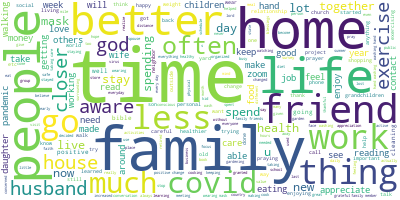

In [3]:
#let's see how this looks with the word cloud and if it needs more manual cleaning 

# Join the different positive responses together.
string_responses = ' '.join(list(responses['pos2_clean'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(string_responses)

# Visualize the word cloud
wordcloud.to_image()

#save the word cloud as a png so I can share it 
#wordcloud.to_file('pos2_wordcloud.png')

In [4]:
#count the frequency of all words in the responses 
def sort_wordfreq(wordstring):
    wordlist = wordstring.split()
    freq = [wordlist.count(w) for w in wordlist]
    freqdict = dict(list(zip(wordlist, freq)))
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [5]:
sort_wordfreq(string_responses)

[(684, 'and'),
 (655, 'more'),
 (621, 'i'),
 (567, 'to'),
 (431, 'my'),
 (387, 'the'),
 (298, 'of'),
 (279, 'with'),
 (276, 'a'),
 (244, 'in'),
 (215, 'time'),
 (209, 'have'),
 (170, 'for'),
 (162, 'family'),
 (137, 'on'),
 (127, 'me'),
 (124, 'we'),
 (122, 'is'),
 (119, 'home'),
 (110, 'out'),
 (102, 'not'),
 (93, 'at'),
 (92, 'that'),
 (89, 'people'),
 (89, 'life'),
 (85, 'has'),
 (83, 'our'),
 (80, 'do'),
 (79, 'am'),
 (77, 'it'),
 (75, 'as'),
 (73, 'friends'),
 (71, 'be'),
 (67, 'better'),
 (67, 'being'),
 (65, 'this'),
 (64, 'from'),
 (63, 'all'),
 (60, 'work'),
 (58, 'things'),
 (58, 'so'),
 (58, 'go'),
 (57, 'less'),
 (57, 'been'),
 (57, 'are'),
 (55, "i'm"),
 (55, 'about'),
 (54, 'no'),
 (52, 'covid'),
 (51, 'much'),
 (47, 'often'),
 (45, 'get'),
 (44, 'was'),
 (44, 'husband'),
 (44, 'house'),
 (44, 'care'),
 (43, 'when'),
 (43, "don't"),
 (43, 'because'),
 (42, 'had'),
 (42, 'god'),
 (42, 'closer'),
 (41, 'aware'),
 (39, 'she'),
 (39, 'mask'),
 (39, 'hands'),
 (38, 'together')

In [30]:
#BIGRAMS AND TRIGRAMS
#from https://nicharuc.github.io/topic_modeling/

In [6]:
#bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in responses.pos2_clean])

# Filter only those that occur at least 10 times?
finder.apply_freq_filter(10)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [7]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

bigram_pmi.head(30)

,bigram,pmi
0,"(thank, you)",8.799536
1,"(hand, washing)",8.320996
2,"(each, other)",8.188101
3,"(every, day)",8.118890
4,"(positive, change)",7.925067
5,"(than, before)",7.526315
6,"(working, from)",6.594918
7,"(made, me)",6.288058
8,"(at, home)",6.264230
9,"(a, lot)",5.945825


In [8]:
#trigrams 

trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in responses.pos2_clean])

# Filter only those that occur at least 10 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)


In [9]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
trigram_pmi.head()

,trigram,pmi
0,"(working, from, home)",13.754451
1,"(a, lot, of)",10.588362
2,"(time, at, home)",10.511493
3,"(spend, more, time)",10.380665
4,"(spending, more, time)",10.268190


In [ ]:
#only want noun type structures? Which of these should I include? 
#how do I handle n-grams with the lemmatizing? 

In [10]:
responses.pos2_clean[799:803]

799                                                   no
800    said her family asks more often if she needs a...
801                                                sleep
802    more cooking at home and trying different reci...
Name: pos2_clean, dtype: object

In [ ]:
#Need to update this! Want this all to be happening in the dataframe 
#so that each response is its own document 

In [11]:
def preprocess(response):
    
    result = []
    wnl = WordNetLemmatizer()
    
    for pair in nltk.pos_tag(nltk.word_tokenize(response)):  
        word = pair[0]
        tag = pair[1]

        #if singular noun, add to the list
        if tag in ["NN", "NNP"]:
            result.append(word)

        elif tag in ["NNS", "NNPS"]:
            #check that it is plural 
            if word[:-1] == "s": 
                result.append(word[:len(word)-1])
            else: 
                #if it's not plural then just add it to the list 
                #(likely singular noun was misidentified)
                result.append(word)

        #verbs 
        elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            result.append(wnl.lemmatize(word, 'v'))

        #not sure if these cases are really needed 

        #adjectives
        elif tag in ["JJ", "JJR", "JJS"]: 
            result.append(wnl.lemmatize(word, 'a'))

        #adverbs 
        elif tag in ["RB", "RBR", "RBS"]: 
            result.append(wnl.lemmatize(word, 'r'))

        #if the word is some other category, just add it to the list without lemmatizing
        else: 
            result.append(word)

    return result

      

In [12]:
preprocessed_responses = responses["pos2_clean"].map(preprocess)
preprocessed_responses.head()

0                           [appreciate, family, more]
1    [my, wife, and, i, do, more, interesting, cook...
2            [more, time, to, myself, not, as, active]
3    [i, wash, my, hands, a, lot, and, i, wear, a, ...
4    [reach, out, to, family, i, have, not, talk, t...
Name: pos2_clean, dtype: object

In [13]:
preprocessed_responses[45:53]

45    [i, love, to, read, and, listen, to, classical...
46    [help, me, to, receive, a, promotion, at, work...
47    [it, have, make, me, more, aware, of, just, ho...
48    [i, switch, jobs, so, now, i, feel, more, comf...
49    [the, stimulus, have, give, the, opportunity, ...
50                                                 [no]
51    [my, daughter, move, home, temporarily, but, i...
52    [more, grateful, for, times, with, family, and...
Name: pos2_clean, dtype: object

In [14]:
#could also just include nouns and maybe verbs? 
#also filter for words > 2 characters 
#from https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

def clean_responses(response_list):
    result = []
    
    stop_words = stopwords.words("english")
    #stop words includes "no" and we want to keep this so we don't end up with missingness 
    stop_words.remove("no")
    my_stops = ["n't", "'ve", "etc"] #could expand this 
    combined_stops = stop_words + my_stops
    
    for word in response_list: 
        if word not in combined_stops and len(word) > 2 or word == "no":
            result.append(word)
    return result    
   


In [63]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
preprocessed_responses = preprocessed_responses.map(clean_responses)
preprocessed_responses.head()

0                                 [appreciate, family]
1                         [wife, interesting, cooking]
2                                       [time, active]
3           [wash, hands, lot, wear, mask, everywhere]
4    [reach, family, talk, often, learn, organize, ...
Name: pos2_clean, dtype: object

In [16]:
len(preprocessed_responses)

943

In [17]:
responses["processed_responses"] = preprocessed_responses

In [18]:
responses.to_csv("responses_processed_105.csv")

In [176]:
#found the NA response that was causing the empty list 
#counter = 255
#for i in range(len(preprocessed_responses)):    
 #   if not preprocessed_responses[i]:
  #      print("r is: ", preprocessed_responses[i])
   #     print("I'm empty")
    #    print("counter is: ", i)


In [ ]:
#LDA 
#https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb

In [19]:
#Now each row of the dataframe is a separate list of lemmatized and cleaned words

#create a dictionary/bag of words of all the words that appear
dictionary = corpora.Dictionary(preprocessed_responses)

In [20]:
#corpus keeps track of the word number in the dictionary and how many times it appears
corpus  = [dictionary.doc2bow(doc) for doc in preprocessed_responses]

In [ ]:
#Gensim parameter explanations 
#https://radimrehurek.com/gensim/models/ldamodel.html

#passes: number of passes through the entire corpus during training
#chunksize: number of documents to be used in each training chunk
#iterations: max number of iterations through corpus when inferring the topic distribution 
#eval_every: log perplexity is estimated every that many updates. Will cause huge slow downs

In [ ]:
#want to include some type of grid searching for hyperparameters 
#use the code from this: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [35]:
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Lda = gensim.models.ldamodel.LdaModel

#grid = {} 

#range of topics - can discuss this I think anything > 10 is too big 
min_topics = 2 
max_topics = 11 
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#Alpha
#small numbers (sparse): each document only represents a few topics
#take the approach from: https://stats.stackexchange.com/questions/349761/reasonable-hyperparameter-range-for-latent-dirichlet-allocation
#range from sparse to non-sparse 

alpha = [0.05, 0.1, 0.5, 1, 5, 10]

#Beta
#small numbers (sparse) produce more and more granular topics 

beta = [0.05, 0.1, 0.5, 1, 5, 10]

#validation sets
#num_of_docs = len(corpus)
#75% and 100% 
#corpus_sets = [gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
             # corpus]

#corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}
            
# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            ldamodel = Lda(corpus=corpus, num_topics=k, id2word = dictionary, passes=10,\
                           chunksize = 100, eval_every = None, alpha = a, eta = b)

            cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=preprocessed_responses,\
                                                             dictionary=dictionary, coherence='c_v')


            cv = cm.get_coherence()
                
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

lda_tuning = pd.DataFrame(model_results)


In [37]:
lda_tuning.to_csv("lda_tuning_105.csv")

In [38]:
lda_tuning

,Topics,Alpha,Beta,Coherence
0,2,0.05,0.05,0.289662
1,2,0.05,0.10,0.251844
2,2,0.05,0.50,0.262655
3,2,0.05,1.00,0.253275
4,2,0.05,5.00,0.373802
...,...,...,...,...
319,10,10.00,0.10,0.359953
320,10,10.00,0.50,0.271948
321,10,10.00,1.00,0.214208
322,10,10.00,5.00,0.205505


In [40]:
max_coherence = lda_tuning["Coherence"].max()
lda_tuning[lda_tuning["Coherence"]== max_coherence]

,Topics,Alpha,Beta,Coherence
309,10,1.0,1.0,0.579235


In [52]:
#What's the mean coherence by topic number 
lda_tuning.groupby(['Topics']).mean()

,Alpha,Beta,Coherence
Topics,,,
2,2.775,2.775,0.297916
3,2.775,2.775,0.316362
4,2.775,2.775,0.335812
5,2.775,2.775,0.346800
6,2.775,2.775,0.352581
7,2.775,2.775,0.362739
8,2.775,2.775,0.371502
9,2.775,2.775,0.372026
10,2.775,2.775,0.376193


In [53]:
#mean coherence by alpha? - looks like 0.5 is slightly the best
lda_tuning.groupby(['Alpha']).mean()

,Topics,Beta,Coherence
Alpha,,,
0.05,6,2.775,0.385848
0.10,6,2.775,0.385358
0.50,6,2.775,0.405057
1.00,6,2.775,0.375991
5.00,6,2.775,0.275821
10.00,6,2.775,0.259879


In [54]:
#mean coherence by beta? - looks like 5 is slightly the best
lda_tuning.groupby(['Beta']).mean()

,Topics,Alpha,Coherence
Beta,,,
0.05,6,2.775,0.330960
0.10,6,2.775,0.326882
0.50,6,2.775,0.337026
1.00,6,2.775,0.348279
5.00,6,2.775,0.374594
10.00,6,2.775,0.370213


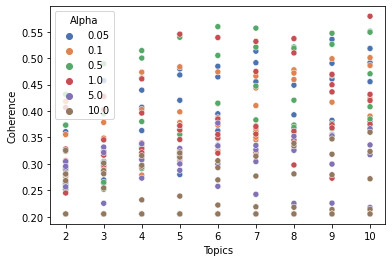

In [50]:
#plot with alpha - any noticeable trends? 
#looks like 0.5 and 1 are performing the best
sns.scatterplot(data=lda_tuning, x='Topics', y='Coherence',  hue='Alpha', palette = "deep");

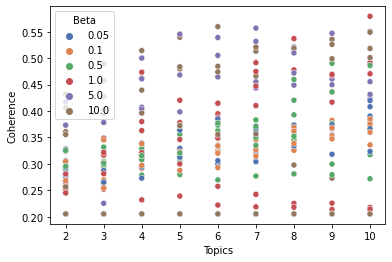

In [51]:
#plot with beta - any trends?
sns.scatterplot(data=lda_tuning, x='Topics', y='Coherence',  hue='Beta', palette = "deep");

In [55]:
#look at the best 10 models by coherence 
lda_tuning_sorted = lda_tuning.sort_values(by=['Coherence'])

In [57]:
lda_tuning_sorted.tail(20)
#let's look at the top 5 models in depth to see which ones make sense
#perhaps 6 topics with alpha 0.5 and beta 10 would be good? 

,Topics,Alpha,Beta,Coherence
227,8,0.10,10.0,0.517677
293,10,0.05,10.0,0.518294
233,8,0.50,10.0,0.518541
231,8,0.50,1.0,0.519265
197,7,0.50,10.0,0.520877
232,8,0.50,5.0,0.521151
269,9,0.50,10.0,0.526054
202,7,1.00,5.0,0.531643
257,9,0.05,10.0,0.535506
237,8,1.00,1.0,0.537013


In [28]:
#let's look at the coherence plots for varying values of k 
#https://nicharuc.github.io/topic_modeling/
#supposed to help with interpretability - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf


#this looks pretty good with passes = 10 and chunksize = 100

coherence = []

for k in range(2,11):
    print('Round: '+str(k))
    #could also use LdaMulticore? 
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k, id2word = dictionary, passes=10,\
                    chunksize = 100, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=preprocessed_responses,\
                                                     dictionary=dictionary, coherence='c_v')
    print("number of topics: ", k, "coherence: ", cm.get_coherence())
    coherence.append((k,cm.get_coherence()))

Round: 2
number of topics:  2 coherence:  0.3471595239326069
Round: 3
number of topics:  3 coherence:  0.32301037836050095
Round: 4
number of topics:  4 coherence:  0.2863708779529264
Round: 5
number of topics:  5 coherence:  0.3257788332709957
Round: 6
number of topics:  6 coherence:  0.30548835735043967
Round: 7
number of topics:  7 coherence:  0.35379837310954754
Round: 8
number of topics:  8 coherence:  0.3450554762339475
Round: 9
number of topics:  9 coherence:  0.37433318896216417
Round: 10
number of topics:  10 coherence:  0.39605951274901297


In [24]:
#look through this in more depth - talks about hyperparameter training 
#https://stats.stackexchange.com/questions/349761/reasonable-hyperparameter-range-for-latent-dirichlet-allocation
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

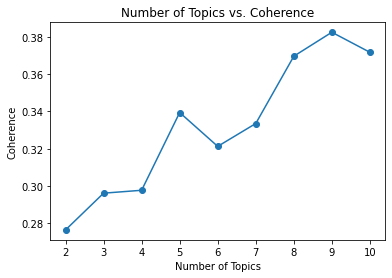

In [27]:
#plot this
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]


plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()



In [ ]:
#this has drastically changed since last time... 
#need to review fully to figure out why this is so unstable and what's causing these differences. 

In [ ]:
#looks like 4, 11 and 19 topics are all good fits. Let's check what these look like in the visualization
#but I have the time, let's run visualizations for all the models 

In [58]:
lda_tuning_sorted.tail(10)

,Topics,Alpha,Beta,Coherence
166,6,1.0,5.0,0.538978
125,5,0.5,10.0,0.539496
124,5,0.5,5.0,0.545016
130,5,1.0,5.0,0.545322
268,9,0.5,5.0,0.547026
305,10,0.5,10.0,0.549031
304,10,0.5,5.0,0.550796
196,7,0.5,5.0,0.556752
161,6,0.5,10.0,0.559598
309,10,1.0,1.0,0.579235


In [13]:

for n in range(2, 21):

    #build LDA model 
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    #lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word=id2word, num_topics=n)

    #print keyword in the topics - see if this is a good split? 
    pprint(lda_model.print_topics())

    # Visualize the topics
    pyLDAvis.enable_notebook()

    LDAvis_data_filepath = "ldavis_914_"+str(n)

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself

    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath +'.html')


/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [36]:
#run for 4 topics (I like this the best)
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    

/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
t1_people = []
t2_work_home = [] 
t3_health = [] 
t4_covid = [] 

for i, row_list in enumerate(lda_model[doc_term_matrix]): 
    row = row_list[0] if lda_model.per_word_topics else row_list

    for topic_score in row:
        
        if topic_score[0] == 0: 
            t1_people.append(topic_score[1])
        
        elif topic_score[0] == 1: 
            t2_work_home.append(topic_score[1])
        
        elif topic_score[0] == 2: 
            t3_health.append(topic_score[1])
        
        elif topic_score[0] == 3: 
            t4_covid.append(topic_score[1])
            
       
        
    

/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
len(t1_people)

/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


910

In [51]:
responses["t1_people_score"] = t1_people
responses["t2_work_home_score"] = t2_work_home
responses["t3_health_score"] = t3_health
responses["t4_covid_score"] = t4_covid

/home/jadebenson/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Length of values (910) does not match length of index (947)